In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import nquad,quad
from tqdm import tqdm

In [2]:
def construct_A(n):
    matrix_A = sp.zeros(n+1)
    pos = []
    for p in range(0, n+1):
        for q in range(0, n+1):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = create_value(matrix_A,item)
    return matrix_A

In [3]:
def create_value(matrix_A,pos):
    fi = basis_list[pos[0]]
    fj = basis_list[pos[1]]
    n_y = K*fi.subs(x,y)*fj
    
    n_y_numpy = sp.lambdify((x,y),n_y,'numpy')
    #n_result = n_taylor_x.integrate((x,begin,end))
    options={'limit':100}
    n_result,_ = nquad(n_y_numpy,[[begin,end],[begin,end]], opts = [options,options])
    matrix_A[pos[0],pos[1]] = n_result
    return matrix_A

In [4]:
def generate_basis(method,begin,end,n):
    x = sp.Symbol('x')
    basis_list = []
    if method == 'linear':
        skip = (end-begin)/n
        for i in tqdm(range(n+1)):
            temp_begin = begin+(i-1)*skip
            temp_end = temp_begin+2*skip
            basis_list.append(sp.Piecewise((0, x < temp_begin),(0, x > temp_end),(1-sp.Abs(x-temp_begin-skip)/skip, True)))
    if method == 'trigo':
        feature = 2*sp.pi/(end-begin)
        for i in tqdm(range(n+1)):
            basis_list.append(sp.cos(i*feature*x))
        for i in tqdm(range(1,n+1)):
            basis_list.append(sp.sin(i*feature*x))
    return basis_list

## 主函数
本程序通过插值法构造退化核，插值点考虑legendre、hebyshev、等距插值，进而求解第二类Fredholm方程。
$$\lambda f(x) - \int_a^{b} k(x,y)f(y) dy = g(x)$$

In [5]:
x = sp.Symbol('x')
y = sp.Symbol('y')
Lambda = 1   
K =sp.exp( x*y)
begin = 0
end = 1
f_origin = 1+5*x+sp.exp(x)
n = 10
method = 'trigo'

In [6]:
g = Lambda*f_origin-(K*f_origin.subs(x,y)).integrate((y,begin,end))
print(f"calculate g")
g

calculate g


5*x - Piecewise((7 - 11*exp(-1), Eq(x, -1)), (5/2 + E, Eq(x, 0)), (E*x**2*exp(x)/(x**3 + x**2) + 6*x**2*exp(x)/(x**3 + x**2) - 2*x**2/(x**3 + x**2) + x*exp(x)/(x**3 + x**2) + 4*x/(x**3 + x**2) - 5*exp(x)/(x**3 + x**2) + 5/(x**3 + x**2), True)) + exp(x) + 1

In [7]:
basis_list = generate_basis(method,begin,end,n)

100%|██████████| 10/10 [00:00<00:00, 4225.15it/s]


In [8]:
if method == 'linear':
    m = n
    h = (end - begin)/n
    Gamma = np.zeros((n+1,n+1))
    Gamma = Gamma+ np.diag(np.ones(n+1)*2*h/3,0)
    temp = np.diag(np.ones(n)*h/6,1)
    Gamma = Gamma+temp+temp.T
    Gamma[0,0] = Gamma[0,0]-h/3
    Gamma[n,n] = Gamma[n,n]-h/3
    Lambda_diag = Lambda*Gamma
elif method == 'trigo':
    m = 2*n
    Gamma = np.zeros((2*n+1,2*n+1))
    Gamma = Gamma+np.diag(np.ones(2*n+1)*(end-begin)/2)
    Gamma[0,0] = end-begin
    Lambda_diag = Lambda*Gamma

In [9]:
K_matrix = construct_A(m)
A_n = Lambda_diag-K_matrix

100%|██████████| 441/441 [00:07<00:00, 58.91it/s] 


In [10]:
# 计算得到 c
y_ = sp.zeros(m+1,1)
for i in tqdm(range(m+1)):
    g_mod = g * basis_list[i]
    g_mod_numpy = sp.lambdify(x,g_mod,'numpy')
    result,err = quad(g_mod_numpy,begin,end)
    y_[i, 0] = result
A_n_acce = np.matrix(A_n).astype(np.float64)
A_n_acce_inv = A_n_acce**(-1)
A_n_inv = sp.Matrix(A_n_acce_inv)
c = A_n_inv*y_

100%|██████████| 21/21 [00:00<00:00, 149.75it/s]


In [11]:
result = 0
for i in range(m+1):
    result = result + basis_list[i]*c[i,0]

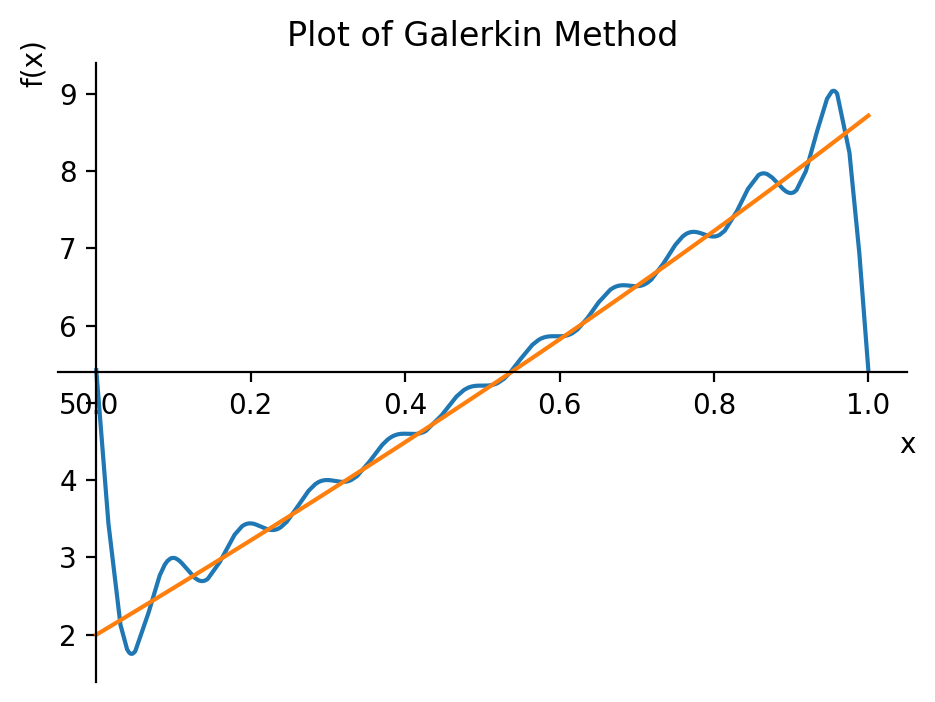

In [12]:
p = sp.plotting.plot(result,(x,begin,end),show=False,title='Plot of Galerkin Method')
p_origin = sp.plotting.plot(f_origin,(x,begin,end),show=False)
p.append(p_origin[0])
p.show()

In [13]:
err_func = sp.lambdify(x,(result-f_origin)**2,'numpy')

In [14]:
err = quad(err_func,begin,end,limit=5*n)
print(f'误差为：{err[0]/(end-begin)}')

误差为：0.22302865140260883
